In [1]:
import warnings
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from import_data import DataImporter
from sentiment_pipeline import SentimentPipeline
from vote_classifier import VoteClassifier

from wordcloud import WordCloud

from nltk import pos_tag
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn import model_selection, naive_bayes, svm
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support as score, classification_report
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# dataset - http://deepyeti.ucsd.edu/jianmo/amazon/index.html

In [2]:
# pd settings
# pd.set_option('display.max_colwidth', None)
# pd.set_option("min_rows", 300)

In [3]:
# pickle load or save data
def pickle_save(data, path):
    file = open(path, 'wb')
    pickle.dump(data, file)
    file.close()
    
def pickle_load(path):
    file = open(path, 'rb')
    data = pickle.load(file)
    file.close()
    return data

In [ ]:
# IMPORT DATA INTO DATAFRAME

data_importer = DataImporter('data/Cell_Phones_and_Accessories_5.json.gz')
df = data_importer.import_data()

In [ ]:
# SHOW DG INFO - NUM OF ENTRIES, COLUMN NAMES AND DTYPES...
df.info()

In [ ]:
# remove random number of rows from df
remove_n = 1000000
# np.random.seed(10)
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df.drop(drop_indices, inplace=True)
pickle_save(df, 'pickles/dataset.pickle')

In [ ]:
df = pickle_load('pickles/dataset.pickle')

In [ ]:
df.info()

In [ ]:
# REMOVE EVERY COLUMN FROM DF, EXCEPT THE ONES SPECIFIED

df.drop(df.columns.difference(['reviewText','overall']), axis=1, inplace=True)

In [ ]:
# RENAME COLUMNS

df.rename(columns={'reviewText': 'review_text'}, inplace=True)

In [ ]:
# GET NEW DF INFORMATION CONTAINING DESIRED COLUMNS

df.info()

In [ ]:
df.head()

In [ ]:
# PLOT OVERALL VALUES USING PYPLOT

plot_size = [10.0, 10.0]
plt.rcParams["figure.figsize"] = plot_size

df["overall"].value_counts().plot(kind="pie", autopct="%1.0f%%")

In [ ]:
# REMOVE ALL ROWS THAT ARE NOT SUITABLE FOR ANALYSIS

df.dropna(subset=['review_text', 'overall'], how='any', inplace=True)
df.drop(df[(df.overall < 4) & (df.overall > 2)].index, inplace=True)


In [ ]:
df.info()

In [ ]:
def generate_most_common_words(text):
    wordcloud = WordCloud(background_color="white", 
                          max_words=150,
                          max_font_size=300,
                          width=1024, 
                          height=500,
                          colormap="Blues"
                         ).generate(text)
    return wordcloud

In [ ]:
# VISUALIZE MOST COMMON WORDS USING WORDCLOUD

text = ' '.join(df['review_text'])
wordcloud = generate_most_common_words(text)
pickle_save(wordcloud, 'pickles/most_common_words.pickle')

In [ ]:
wordcloud = pickle_load('pickles/most_common_words.pickle')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()   

In [ ]:
def resolve_sentiment(overall):
    if overall > 3:
        return 'pos'
    return 'neg'

In [ ]:
df['sentiment'] = df['overall'].apply(lambda overall: resolve_sentiment(overall))

In [ ]:
df.head()

In [ ]:
# CHECK HOW MANY POSITIVE AND NEGATIVE REVIEWS ARE IN THE DF

num_of_pos_and_neg_reviews = df['sentiment'].value_counts()

num_of_pos_reviews = num_of_pos_and_neg_reviews['pos']
num_of_neg_reviews = num_of_pos_and_neg_reviews['neg']

print(num_of_pos_and_neg_reviews)

In [ ]:
# VISUALIZE SENTIMENTS USING SEABORN

sns.countplot(x=df['sentiment'])

In [ ]:
# UPSAMPLING / DOWNSAMPLING

df_pos = df[(df['sentiment']=='pos')] 
df_neg = df[(df['sentiment']=='neg')] 

# DOWNSAMPLING
# df_majority_downsampled = resample(df_pos, 
#                                  replace=True,   
#                                  n_samples= num_of_neg_reviews, 
#                                  random_state=42)  
# df = pd.concat([df_majority_downsampled, df_neg])

# UPSAMPLING
df_minority_upsampled = resample(df_neg, 
                                 replace=True,   
                                 n_samples= num_of_pos_reviews, 
                                 random_state=42) 
df = pd.concat([df_minority_upsampled, df_pos])

In [ ]:
# CHECK IF SENTIMENTS ARE DOWNSAMPLED / UPSAMPLED

sns.countplot(x=df['sentiment'])

In [ ]:
def run_sentiment_pipeline(text):
    pipeline = SentimentPipeline(text)
    return pipeline.run()

In [ ]:
# CREATE WORD TOKENS FOR EVERY DF ROW

df['tokens'] = df['review_text'].apply(lambda text: run_sentiment_pipeline(text))
pickle_save(df, 'pickles/tokenized_dataset.pickle')

In [ ]:
df = pickle_load('pickles/tokenized_dataset.pickle')

In [ ]:
df.head(20)

In [ ]:
# PLOT MOST COMMON TOKENS USING FREQDIST

fdist = FreqDist(np.concatenate(df['tokens'].values))
pickle_save(fdist, 'pickles/most_common_tokens.pickle')

In [ ]:
fdist = pickle_load('pickles/most_common_tokens.pickle')
fdist.most_common(20)
fdist.plot(20)

In [ ]:
wordnet_pos = {
    "J": wordnet.ADJ,
    "V": wordnet.VERB,
    "N": wordnet.NOUN,
    "R": wordnet.ADV
}

def get_token_with_pos_tag(word, tag):
    if tag in wordnet_pos:
        return (word, wordnet_pos[tag])
    else:
        return (word, None)  

def get_tokens_with_pos_tags(tokens):
    tokes_with_pos = []
    allowed_word_types = ["J", "V", "R", "I", "C", "N"]
    # allowed_word_types = ["J", "C", "R"]

    for f in pos_tag(tokens):
        if f[1][0] in allowed_word_types:
            tokes_with_pos.append(get_token_with_pos_tag(f[0], f[1][0]))    
                                
    return tokes_with_pos

In [ ]:
# GET TOKENS WITH THEIR POS TAGS

df['tokens_with_pos_tags'] = df['tokens'].apply(lambda tokens: get_tokens_with_pos_tags(tokens))
pickle_save(df, 'pickles/tokenized_dataset_with_pos_tags.pickle')

In [ ]:
df = pickle_load('pickles/tokenized_dataset_with_pos_tags.pickle')

In [ ]:
df.head()

In [ ]:
# from nltk.corpus import stopwords
# import nltk
# df['bigrams'] = df['features'].apply(lambda row: list(nltk.bigrams(row)))

# stopwords.words("english")

# print(pos_tag(['but', 'terrific', 'fits', 'thank', 'love', 'super', 'shine', 'excellent', 'junk', 'awesome']))

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word, tag):
    if tag is None:
        return lemmatizer.lemmatize(word)
    
    return lemmatizer.lemmatize(word, pos=tag)   

def lemmatize_tokens(tokens):
    res = ""
    for token in tokens:
        res += lemmatize_word(token[0], token[1]) + " "
        
    return res.strip()

In [ ]:
# PERFORM LEMMATIZATION

df['lemmatized_text']=df['tokens_with_pos_tags'].apply(lambda tokens: lemmatize_tokens(tokens))

In [ ]:
df.head()

In [ ]:
# LABEL SENTIMENTS USING LABELENCODER

label_encoder = preprocessing.LabelEncoder()
  
# encode labels in column 'sentiment'.
df['sentiment_encoded']= label_encoder.fit_transform(df['sentiment'])

In [ ]:
df.head()

In [ ]:
df.drop(df.columns.difference(['overall','review_text', 'sentiment_encoded', 'lemmatized_text']), axis=1, inplace=True)
pickle_save(df, 'pickles/lemmatized_encoded_dataset.pickle')

In [4]:
df = pickle_load('pickles/lemmatized_encoded_dataset.pickle')

In [6]:
df

,overall,review_text,lemmatized_text,sentiment_encoded
512431,2.0,Case is fine looking.. One problem I'm coming ...,case fine look one problem come screen peal on...,0
1123878,2.0,"Too cheap for my liking, one drop and the case...",too cheap like one drop case fels like break n...,0
44086,1.0,Doesn't work,not work,0
363581,1.0,Tried and tried but never could get it to stay...,try tried but never get stay screen apply scre...,0
972393,1.0,didn't even fit!,not even fit,0
...,...,...,...,...
1128407,5.0,Fits my phone nicely. I love that it really do...,fit phone nicely love really repel skin oil sm...,1
1128408,4.0,Not sure if I like this. It's thicker than my ...,not sure like thicker former protective screen...,1
1128413,5.0,Works Great,work great,1
1128421,5.0,SUPER CUTE - Time will tell if image wipes off...,super cute time tell image wipe silicone,1


In [5]:
# SPLIT THE DATA INTO TRAINING, VALIDATION AND TEST SETS

X_train,X_temp,Y_train, Y_temp = train_test_split(df['lemmatized_text'], df['sentiment_encoded'], train_size=0.8, random_state=30)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=31)


print("X_train: {}, Y_train: {}".format(X_train.shape, Y_train.shape))
print("X_valid: {}, Y_valid: {}".format(X_valid.shape, Y_valid.shape))
print("X_test: {}, Y_test: {}".format(X_test.shape, Y_test.shape))

X_train: (162166,), Y_train: (162166,)
X_valid: (20271,), Y_valid: (20271,)
X_test: (20271,), Y_test: (20271,)


In [7]:
# APPLY TF-IDF VECTORIZER - CONVERT TEXT TO NUMERICAL VALUES

vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=15000)
tf_x_train = vectorizer.fit_transform(X_train)

pickle_save(vectorizer, 'pickles/tfidf_vectorizer.pickle')

In [6]:
vectorizer = pickle_load('pickles/tfidf_vectorizer.pickle')
tf_x_valid = vectorizer.transform(X_valid)
tf_x_test = vectorizer.transform(X_test)

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

In [ ]:
# visualize most common words after preprocessing
text = ' '.join(df['lemmatized_text'])
wordcloud = generate_most_common_words(text)
pickle_save(wordcloud, 'pickles/most_common_lemmatized_words.pickle')

In [1]:
wordcloud = pickle_load('pickles/most_common_lemmatized_words.pickle')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()   

NameError: name 'pickle_load' is not defined

In [ ]:
# num of negative reviews
df[df['sentiment_encoded'] == 0].count()

In [ ]:
# num of positive reviews
df[df['sentiment_encoded'] == 1].count()

In [8]:
def run_gridsearch(x, y, model, parameters, scoring, cv):
    clf = GridSearchCV(model,                    # model
                       param_grid = parameters,   # hyperparameters
                       scoring=scoring,        # metric for scoring
                       cv=cv)                     # number of folds

    clf.fit(x, y)    
    return (clf.best_params_, clf.best_score_)

In [11]:
warnings.filterwarnings('ignore')

parameters = {
    'alpha': [0.5, 0.7, 1.0]
}

multinomial_nb = naive_bayes.MultinomialNB()
params_and_score = run_gridsearch(tf_x_train, Y_train, multinomial_nb, parameters, 'accuracy', 5)

print("Tuned Hyperparameters :", params_and_score[0])
print("Accuracy :", params_and_score[1]) 

Tuned Hyperparameters : {'alpha': 0.5}
Accuracy : 0.9109554256877092


In [ ]:
# MULTINOMIAL NB

multinomial_nb_classifier = naive_bayes.MultinomialNB(alpha=0.5)
multinomial_nb_classifier.fit(tf_x_train,Y_train)

# pickle multinomial nb
pickle_save(multinomial_nb_classifier, 'pickles/multinomial_nb_tf_classifier.pickle')

In [9]:
multinomial_nb_tf_classifier = pickle_load('pickles/multinomial_nb_tf_classifier.pickle')
# predict the labels on validation dataset
predictions_multinomial_nb_tf = multinomial_nb_tf_classifier.predict(tf_x_valid)
# Use accuracy_score function to get the accuracy
multinomial_nb_tf_accuracy = accuracy_score(predictions_multinomial_nb_tf, Y_valid)*100
print("Multinomial Naive Bayes Accuracy Score -> ", multinomial_nb_tf_accuracy)

Multinomial Naive Bayes Accuracy Score ->  91.09072073405358


In [10]:
# MULTINOMIAL NB - CONFUSION MATRIX, PRECISION, RECALL, FSCORE

print("Confusion matrix")
print(confusion_matrix(Y_valid, predictions_multinomial_nb_tf))
print("----------------------------------------------------------------")
print("Classification report")
print(classification_report(Y_valid, predictions_multinomial_nb_tf))

Confusion matrix
[[9414  712]
 [1094 9051]]
----------------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10126
           1       0.93      0.89      0.91     10145

    accuracy                           0.91     20271
   macro avg       0.91      0.91      0.91     20271
weighted avg       0.91      0.91      0.91     20271



In [ ]:
# GAUSSIAN NB

gaussian_nb_classifier = naive_bayes.GaussianNB()
gaussian_nb_classifier.fit(tf_x_train.toarray(),Y_train)

# pickle gaussian nb
pickle_save(gaussian_nb_classifier, 'pickles/gaussian_nb_tf_classifier.pickle')

In [11]:
gaussian_nb_classifier = pickle_load('pickles/gaussian_nb_tf_classifier.pickle')
# predict the labels on validation dataset
predictions_gaussian_nb_tf = gaussian_nb_classifier.predict(tf_x_valid.toarray())
# Use accuracy_score function to get the accuracy
gaussian_nb_tf_accuracy = accuracy_score(predictions_gaussian_nb_tf, Y_valid)*100
print("Gaussian Naive Bayes Accuracy Score -> ", gaussian_nb_tf_accuracy)

Gaussian Naive Bayes Accuracy Score ->  88.85106802821765


In [12]:
# GAUSSIAN NB - CONFUSION MATRIX

print("Confusion matrix")
print(confusion_matrix(Y_valid, predictions_gaussian_nb_tf))
print("-----------------------------------------------------------------")
print("Classification report")
print(classification_report(Y_valid, predictions_gaussian_nb_tf))

Confusion matrix
[[9174  952]
 [1308 8837]]
-----------------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10126
           1       0.90      0.87      0.89     10145

    accuracy                           0.89     20271
   macro avg       0.89      0.89      0.89     20271
weighted avg       0.89      0.89      0.89     20271



In [ ]:
# BERNOULLI NB

bernoulli_nb_classifier = naive_bayes.BernoulliNB(binarize=0.0)
bernoulli_nb_classifier.fit(tf_x_train,Y_train)
# predict the labels on validation dataset
predictions_bernoulli_nb = bernoulli_nb_classifier.predict(tf_x_valid)
# Use accuracy_score function to get the accuracy
bernoulli_nb_accuracy = accuracy_score(predictions_bernoulli_nb, Y_valid)*100
print("Bernoulli Naive Bayes Accuracy Score -> ", bernoulli_nb_accuracy)

# pickle bernoulli nb
# pickle("bernoulli_nb_classifier.pickle", bernoulli_nb_classifier)

In [ ]:
# BERNOULLI NB - CONFUSION MATRIX, PRECISION, RECALL, FSCORE

print("Confusion matrix")
print(confusion_matrix(Y_valid, predictions_bernoulli_nb))
print("------------------------------------------------------------")
print("Classification report")
print(classification_report(Y_valid, predictions_bernoulli_nb))

In [ ]:
# LOGISTIC REGRESSION - PARAMETER TUNING

# remove warnings from GridSearchCV
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [],
}

logreg = LogisticRegression()
params_and_score = run_gridsearch(tf_x_train, Y_train, logreg, parameters, 'accuracy', 5)

print("Tuned Hyperparameters :", params_and_score[0])
print("Accuracy :", params_and_score[1]) 

In [ ]:
# LOGISTIC REGRESSION WITH BEST PARAMS
    
logreg_classifier = LogisticRegression(penalty='l2', C=100.0)
logreg_classifier.fit(tf_x_train,Y_train)

# pickle multinomian nb
pickle_save(logreg_classifier, 'pickles/logreg_classifier.pickle')

In [13]:
# LOGISTIC REGRESSION - CONFUSION MATRIX, PRECISION, RECALL, FSCORE
logreg_classifier = pickle_load('pickles/logreg_classifier.pickle')

# predict the labels on validation dataset
predictions_logreg = logreg_classifier.predict(tf_x_valid)
# Use accuracy_score function to get the accuracy
logistic_regression_accuracy = accuracy_score(predictions_logreg, Y_valid)*100
print("Logistic Regression Accuracy Score -> ", logistic_regression_accuracy)

print("Confusion matrix")
print(confusion_matrix(Y_valid, predictions_logreg))
print("--------------------------------------------------------------------")
print("Classification report")
print(classification_report(Y_valid, predictions_logreg))

Logistic Regression Accuracy Score ->  96.04854225247891
Confusion matrix
[[9877  249]
 [ 552 9593]]
--------------------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10126
           1       0.97      0.95      0.96     10145

    accuracy                           0.96     20271
   macro avg       0.96      0.96      0.96     20271
weighted avg       0.96      0.96      0.96     20271



In [12]:
# SVM - PARAMETER TUNING

parameters = {
    'C': np.arange(0.01,100,10), 
}

svc = svm.LinearSVC(max_iter=1000000)
params_and_score = run_gridsearch(tf_x_train, Y_train, svc, parameters, 'accuracy', 5)

print("Tuned Hyperparameters :", params_and_score[0])
print("Accuracy :", params_and_score[1]) 

Tuned Hyperparameters : {'C': 10.01}
Accuracy : 0.9566616859317681


In [13]:
# LINEAR SVM

# fit the training dataset on the classifier
svm_classifier = svm.LinearSVC(C=10.01)
svm_classifier.fit(tf_x_train,Y_train)


# pickle svm
pickle_save(svm_classifier, 'pickles/svm_classifier.pickle')

In [14]:
svm_classifier = pickle_load('pickles/svm_classifier.pickle')
# predict the labels on validation dataset
predictions_SVM = svm_classifier.predict(tf_x_valid)
# Use accuracy_score function to get the accuracy
svm_accuracy = accuracy_score(predictions_SVM, Y_valid)*100
print("SVM Accuracy Score -> ", svm_accuracy)

SVM Accuracy Score ->  95.76735237531449


In [14]:
# LINEAR SVM - CONFUSION MATRIX, PRECISION, RECALL, FSCORE

print("Confusion matrix")
print(confusion_matrix(Y_valid, predictions_SVM))
print("--------------------------------------------------------------------")
print("Classification report")
print(classification_report(Y_valid, predictions_SVM))

Confusion matrix
[[9960  166]
 [ 692 9453]]
--------------------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10126
           1       0.98      0.93      0.96     10145

    accuracy                           0.96     20271
   macro avg       0.96      0.96      0.96     20271
weighted avg       0.96      0.96      0.96     20271



In [15]:
# DUMMY CLASSIFIER

strategies = ['most_frequent', 'stratified', 'uniform', 'constant']

for st in strategies:
    if st == "constant":
        dummy_clf = DummyClassifier(strategy=st, random_state=None, constant=1)
    else:
        dummy_clf = DummyClassifier(strategy=st, random_state=None)
    dummy_clf.fit(tf_x_train, Y_train)
    predictions_dummy = dummy_clf.predict(tf_x_valid)
    print("Dummy classifier with {} strategy accuracy score -> {}".format(st, accuracy_score(predictions_dummy, Y_valid)*100))

Dummy classifier with most_frequent strategy accuracy score -> 49.953135020472594
Dummy classifier with stratified strategy accuracy score -> 50.13072862710276
Dummy classifier with uniform strategy accuracy score -> 50.027132356568494
Dummy classifier with constant strategy accuracy score -> 50.046864979527406


In [16]:
# VOTE CLASSIFIER
    
vote_classifier = VoteClassifier(
                            multinomial_nb_tf_classifier, 
                            logreg_classifier, 
                            svm_classifier)

predictions_vote_classifier = vote_classifier.classify(tf_x_valid)
vote_classifier_valid_accuracy = accuracy_score(predictions_vote_classifier, Y_valid)*100
print("Vote Classifier Valid Accuracy Score -> ", vote_classifier_valid_accuracy)

Vote Classifier Valid Accuracy Score ->  96.05840856395837


In [17]:
predictions_multinomial_nb_tf = multinomial_nb_tf_classifier.predict(tf_x_test)
multinomial_nb_test_accuracy = accuracy_score(predictions_multinomial_nb_tf, Y_test)*100
print("Multinomia NB Test Accuracy Score -> ", multinomial_nb_test_accuracy)

predictions_gaussian_nb = gaussian_nb_classifier.predict(tf_x_test.toarray())
gaussian_nb_test_accuracy = accuracy_score(predictions_gaussian_nb_tf, Y_test)*100
print("Gaussian NB Test Accuracy Score -> ", gaussian_nb_test_accuracy)

predictions_svm = svm_classifier.predict(tf_x_test)
svm_test_accuracy = accuracy_score(predictions_svm, Y_test)*100
print("SVM Test Accuracy Score -> ", svm_test_accuracy)

predictions_logreg = logreg_classifier.predict(tf_x_test)
logreg_test_accuracy = accuracy_score(predictions_logreg, Y_test)*100
print("Logistic regression Test Accuracy Score -> ", logreg_test_accuracy)

predictions_vote_classifier = vote_classifier.classify(tf_x_test)
vote_classifier_test_accuracy = accuracy_score(predictions_vote_classifier, Y_test)*100
print("Vote Classifier Test Accuracy Score -> ", vote_classifier_valid_accuracy)

Multinomia NB Test Accuracy Score ->  91.06605495535493
Gaussian NB Test Accuracy Score ->  49.765675102362984
SVM Test Accuracy Score ->  95.71802081791722
Logistic regression Test Accuracy Score ->  95.84134971141039
Vote Classifier Test Accuracy Score ->  96.05840856395837


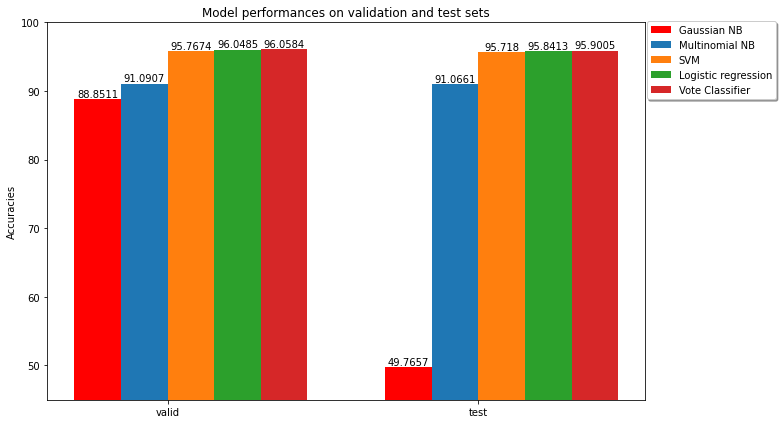

In [18]:
sets = ['valid', 'test']
multinomial_nb_accuracies = [multinomial_nb_tf_accuracy, multinomial_nb_test_accuracy]
gaussian_nb_accuracies = [gaussian_nb_tf_accuracy, gaussian_nb_test_accuracy]
logistic_regression_accuracies = [logistic_regression_accuracy, logreg_test_accuracy]
svm_accuracies = [svm_accuracy, svm_test_accuracy]
vote_classifier_accuracies = [vote_classifier_valid_accuracy, vote_classifier_test_accuracy]

fig, ax = plt.subplots(figsize=(11, 6))
x = np.array([0, 2])
width = 0.3

bar1 = ax.bar(x - 3*width/2, gaussian_nb_accuracies, width, color="red", label="Gaussian NB")
bar2 = ax.bar(x - width/2, multinomial_nb_accuracies, width, label='Multinomial NB')
bar3 = ax.bar(x + width/2, svm_accuracies, width, label="SVM")
bar4 = ax.bar(x + 3*width/2, logistic_regression_accuracies, width, label="Logistic regression")
bar5 = ax.bar(x + 5*width/2, vote_classifier_accuracies, width, label="Vote Classifier")

ax.set_ylim([45, 100])

ax.set_ylabel('Accuracies')
ax.set_title('Model performances on validation and test sets')
ax.set_xticks(x, sets)

ax.legend(loc='center', bbox_to_anchor=(1.11, 0.90), shadow=True)

ax.bar_label(bar1)
ax.bar_label(bar2)
ax.bar_label(bar3)
ax.bar_label(bar4)
ax.bar_label(bar5)
 
fig.tight_layout()

plt.show()